In [6]:
##TODO -> try LLM models (chat gpt or bert), 
# would be good to use both title and body

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import requests
from tqdm import tqdm
import xgboost as xgb
tqdm.pandas()

In [34]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv").sample(2000)

In [35]:
# Actually there is no need to split it here, only to stay consistent with other notebooks
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

In [36]:
file_path = r"C:\Users\Mateusz\Desktop\api_key_chat_gpt_kubita.txt" 

with open(file_path, 'r') as file:
    api_key = file.read()

# Direct prompt 

In [42]:
def batch_get_chat_gpt_answers(titles, batch_size=50):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    results = []
    
    for i in tqdm(range(0, len(titles), batch_size), desc="Processing Batches"):
        batch = titles[i:i + batch_size]
        
        batch_results = []
        for title in batch:
            response = requests.post(url, headers=headers, json={
                "model": "gpt-4",
                "messages": [
                    {
                        "role": "user",
                        "content":f"You are an assistant that classifies article title as clickbait or not. Return only '1' if the news title appears to be clickbait, and only '0' if it seems legitimate. Do not provide any additional text or explanations. Here is the title: {title}"

                    },
                ],
            }).json()
            
            answer = response["choices"][0]["message"]["content"]
            
            try:
                answer_int = int(answer.strip())
            except ValueError:
                print('There was value error')
                answer_int = 0  # Default to 0 if the model returns unexpected text
            
            batch_results.append(answer_int)
        
        results.extend(batch_results)
    
    return results

In [ ]:
pred = batch_get_chat_gpt_answers(x_test.tolist())

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       208
           1       0.87      0.67      0.76       192

    accuracy                           0.79       400
   macro avg       0.81      0.79      0.79       400
weighted avg       0.81      0.79      0.79       400



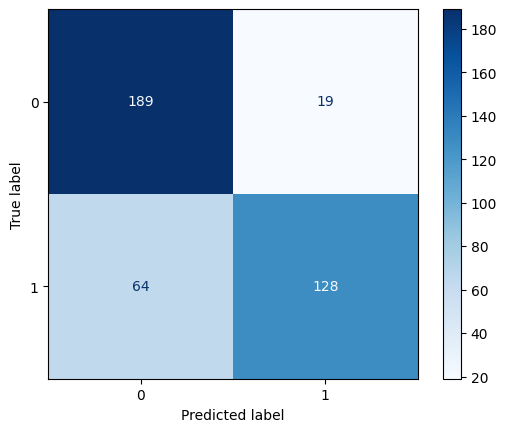

In [47]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Embeddings

In [ ]:
def return_embeddings_chat(prompt):
    res = requests.post(f"https://api.openai.com/v1/embeddings",
        headers = {
          "Content-Type": "application/json",
          "Authorization": f"Bearer {api_key}"
        },
        json={
          "model": "text-embedding-3-large",
          "encoding_format": "float",
          "input": f"{prompt}"
        }).json()
    return res["data"][0]["embedding"]

In [25]:
def batch_embeddings(prompts, batch_size=250):
    url = "https://api.openai.com/v1/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    embeddings = []
    for i in tqdm(range(0, len(prompts), batch_size), desc="Processing Batches"):
        batch = prompts[i:i + batch_size]
        response = requests.post(url, headers=headers, json={
            "model": "text-embedding-3-large",
            "encoding_format": "float",
            "input": batch
        }).json()
        embeddings.extend([item["embedding"] for item in response["data"]])
    return embeddings

embeddings_train = batch_embeddings(x_train.tolist())
embeddings_x_train_df = pd.DataFrame(embeddings_train)

embeddings_test = batch_embeddings(x_test.tolist())
embeddings_x_test_df = pd.DataFrame(embeddings_test)

Processing Batches: 100%|██████████████████████████████████████████████████████████████| 16/16 [01:20<00:00,  5.02s/it]


In [31]:
embeddings_x_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.007708,0.002197,-0.014086,0.014623,-0.008665,-0.006117,-0.017423,0.028887,-0.000700,-0.000989,...,-0.018060,0.030225,-0.023598,0.024703,-0.006082,-0.007187,-0.008532,0.000581,-0.013207,0.010376
1,0.003838,0.015038,-0.017042,-0.000516,0.022288,-0.011407,0.011695,0.003888,-0.007381,0.019684,...,-0.009091,-0.005672,-0.007169,0.000538,0.011958,-0.000009,0.004267,0.003584,-0.012947,-0.004527
2,0.008249,-0.034727,-0.002449,-0.062764,-0.028221,0.033678,0.013288,0.001389,0.012948,-0.011091,...,0.014713,-0.006832,0.006414,0.001363,-0.014670,0.001666,0.013253,-0.007307,-0.020680,0.011970
3,0.016529,-0.026904,-0.019269,-0.006891,0.016948,-0.033656,0.030542,0.021529,-0.005573,0.034555,...,-0.016274,0.008182,-0.003741,-0.008175,0.026590,-0.010345,0.014987,0.012060,0.010600,-0.019673
4,0.008426,-0.036027,-0.021843,-0.001583,-0.021856,-0.024984,-0.000015,0.022546,-0.040112,0.033806,...,-0.018971,0.012045,0.025852,-0.006297,-0.017452,0.000578,0.012518,-0.000217,-0.018116,0.007788


# Model fitting with embeddings

0.844
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2019
           1       0.88      0.80      0.84      1981

    accuracy                           0.84      4000
   macro avg       0.85      0.84      0.84      4000
weighted avg       0.85      0.84      0.84      4000



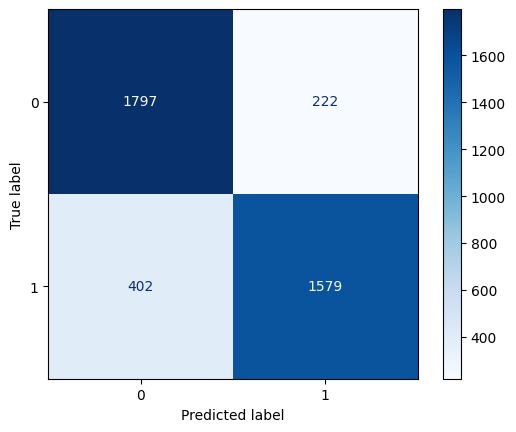

In [29]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)

pred_rf = RF.predict(embeddings_x_test_df)
print(RF.score(embeddings_x_test_df, y_test))
print(classification_report(y_test, pred_rf))

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2019
           1       0.87      0.82      0.84      1981

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



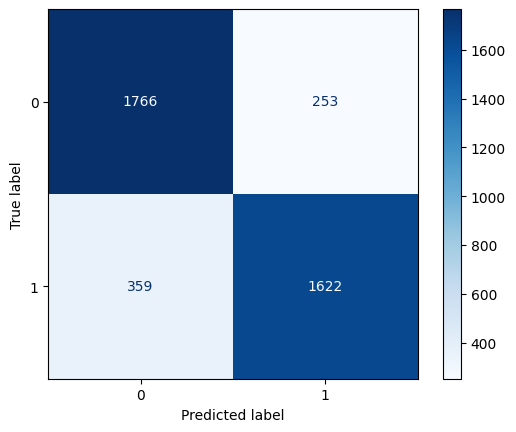

In [30]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)

pred_xgb = xgb_model.predict(embeddings_x_test_df)

cm = confusion_matrix(y_test, pred_xgb)
print(classification_report(y_test, pred_xgb))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()